# 準ニュートン法の実装解説
- 本notebookでは、以下コードの解説をしていきます
- https://github.com/ysakamot15/optimization
- 勉強会資料：　https://drive.google.com/drive/u/1/folders/1hUG_39oZhNRpL2WeR5YfISSGh2RF1xun

### 準備1　目的関数を定義します
- 目的関数： $ (x_1 - 2)^4 + (x_1 - 2x_2)^2 $
- 勾配　$\nabla f$:
\begin{matrix}
    (4(x_1-2)^3 + 2(x_1-2x_2) \\
    -4(x_1 - 2x_2))
\end{matrix}

In [26]:
from IPython.display import Image
import numpy as np

#目的関数オブジェクトを用意します
class objective_test_sample:
    def __init__(self):
        self.dim = 2
    def func(self, x):
        return (x[0] - 2) ** 4 + (x[0] - 2 * x[1]) ** 2
    def grad(self, x):
        return np.array([4 * (x[0] - 2) ** 3 + 2 * (x[0] - 2 * x[1]),
                        -4 *  (x[0] - 2 * x[1])])

### 準備2　ステップ幅αをアルミホ条件に基づいて計算する関数を用意します
- ニュートン法では収束方向$d$が求まった後、ステップ幅αを計算して、解の更新（$x^{k+1} = x ^k + αd$）を行います
- $g(α)$を、$x$において目的関数$f(x)$が$d$の方向にαの幅で向かう関数と定義します：
$\\ g(α) = f(x^k + αd(x^k)) $
- アルミホ条件はある定数 0 < τ < 1 に対してαが以下を満たすことです：
$ g(α) \leq g(0) + τg^{\prime}(0)α $
- 上記を満たすαを、betaで更新して条件へのあてはまりを確認しながら漸化計算していきます。

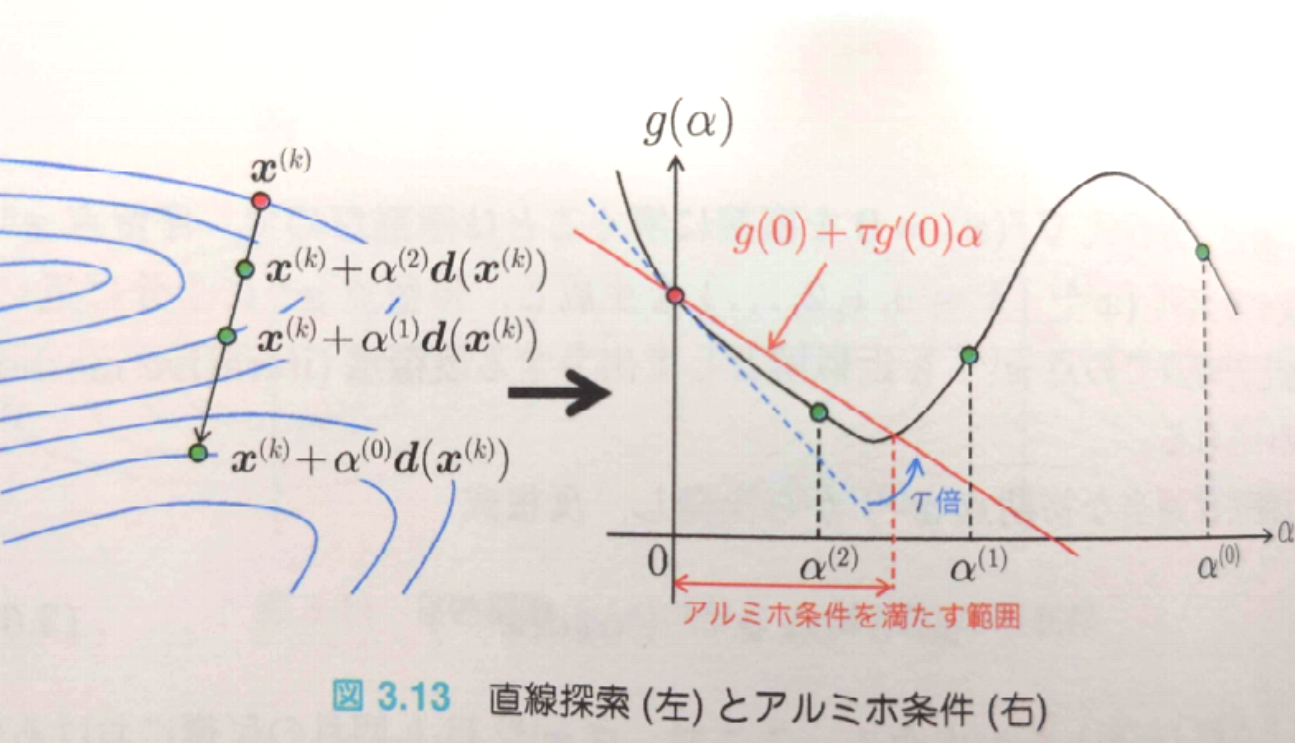

In [27]:
Image("image/almiho.jpg")

In [28]:
#後で出てきますが、tau1は0.5, betaは0.9とパラメータ指定しています。深くは気にしなくていいかなと思います
def backtracking_line_search(objective, x, d, tau1, beta):
    alpha = 1
    g = lambda alpha : objective.func(x + alpha * d)
    g_dash = lambda alpha : objective.grad(x + alpha * d) @ d
    while(1):
        if ((g(alpha) <= g(0) + tau1 * g_dash(0) * alpha)):
                break
        alpha *= beta
    return alpha

### 本番：準ニュートン法の手続き通り実行していきます
---
1. 適当な初期点（正定値）を決めて、$H_0$の近似正定値行列 $B_0$を作ります
2. $ \nabla f(x^k) $ が十分小さければ終了します（※終了条件なので最初は無視）
3. $ d(x^k) = -B^{-1} \nabla f(x^k) $ に沿って、直線探索しアルミホ条件を満たすステップ幅αを求めます
4. $ x^{k+1} = x^k + α_kd(x^k) $ として更新します
5. みんな大好きBFGS公式を使って、$B_{k+1}$を作ります
---

In [29]:
def quasi_newton(objective, eps = 1e-9, tau1 = 0.5, beta = 0.9):
    # ステップ１. 適当な初期の正定値行列Bを決めます。単位行列は正定値行列です
    H = np.eye(objective.dim) # = inv(B)
    # 同様に、探索の初期値を適当に用意します
    x = np.random.randn(objective.dim)

    while(1):
        #ステップ２（終了条件）：勾配がめっちゃ小さければ終了
        grad = objective.grad(x)
        if(np.linalg.norm(grad) <= eps):
            break
        #ステップ３：dを求めます。Hとありますが中身はBです
        d = - H @ grad
        #　d方向へのステップ幅をアルミホ条件で決めます
        alpha = backtracking_line_search(objective, x, d, tau1, beta)
        #　次のxが決まりました
        x_new = x + alpha * d
        # みんな大好きBFGS公式です
        s = (x_new - x)[:, None]
        y = (objective.grad(x_new) - grad)[:, None]
        I = np.eye(H.shape[0])
        sy = (s.T @ y)
        H = (I - (s @ y.T) / sy)  @ H @ (I - (y @ s.T) / sy) + (s @ s.T / sy)
        x = x_new
    return x, objective.func(x)

In [30]:
objective = objective_test_sample()
print("最適解, 目的値：")
print(quasi_newton(objective, eps=1e-6))

最適解, 目的値：
(array([1.99453618, 0.99726808]), 8.912206060007764e-10)


## 例題：施設配置問題
- 今度は以下、４つの倉庫に対する合計距離を最小化する拠点配置問題を定式化して解いてみます
- 本当は入力インタフェースを整えたらよいのですが割愛してだらだら書きます

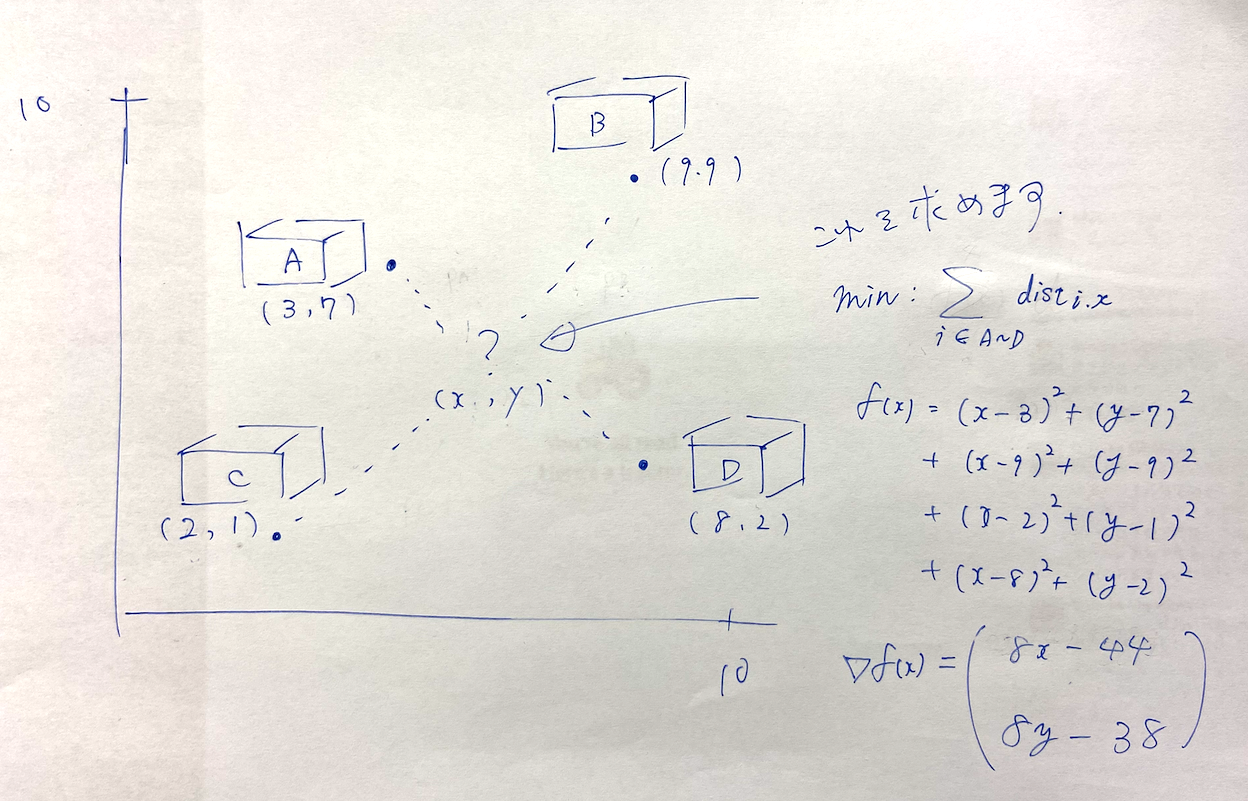

In [33]:
Image("image/depo.png")

In [34]:
class objective_depo:
    def __init__(self):
        self.dim = 2
    def func(self, x):
        return (x[0] - 3) ** 2 + (x[1] - 7) ** 2 + (x[0] - 9) ** 2 + (x[1] - 9) ** 2 +\
            (x[0] - 2) ** 2 + (x[1] - 1) ** 2 + (x[0] - 8) ** 2 + (x[1] - 2) ** 2
    def grad(self, x):
        return np.array([8 * x[0] - 44,8 * x[1] - 38])

In [35]:
objective = objective_depo()
print("最適解, 目的値：")
print(quasi_newton(objective, eps=1e-6))

最適解, 目的値：
(array([5.5 , 4.75]), 81.74999999999999)
